# Wide & Deep Learning for Recommender System

- Google에서 App Store를 활용해서 발표한 논문



- Widel Models
  - memorization에 강하고, user의 특이 취향이 반영된 niche combination을 학습하기에 좋음
  - 0이 되는 pair는 학습이 불가능한 단점이 존재
  - 두 feature를 cross-product한 결과 x를 input으로 사용
    (여기서의 cross-product는 선형대수의 cross-product와는 다른 개념)

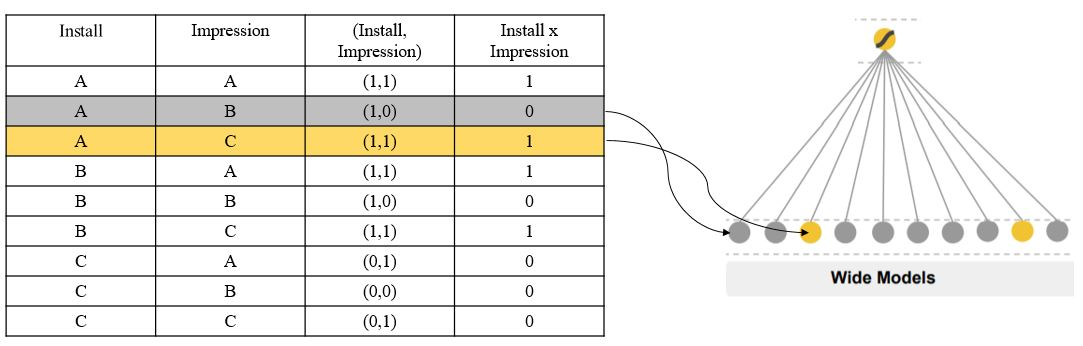

- Deep Models
  - generalization에 특화됨
  - continuous feature와 임베딩된 categorical feature를 concat한 결과 a를 input으로 사용
  - 임베딩 공간 내에서 표현하므로 pair가 없는 관계도 표현 가능
   (하지만 충분한 정보가 부족하므로 제대로 된 임베딩 벡터를 얻지 못할 가능성이 큼)

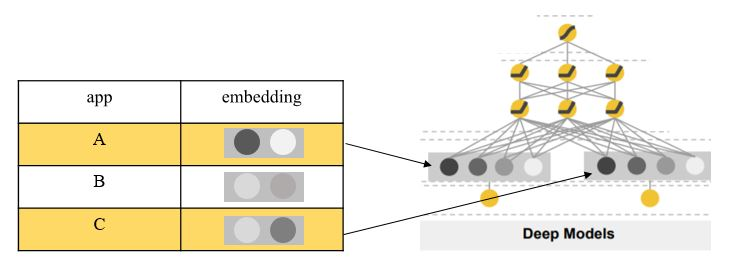

In [1]:
!pip install pytorch-widedeep

     |████████████████████████████████| 25.1 MB 54.0 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 396 kB 51.4 MB/s 
     |████████████████████████████████| 15.7 MB 16.2 MB/s 
     |████████████████████████████████| 173 kB 47.6 MB/s 
     |████████████████████████████████| 124 kB 29.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Loader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/data/kmrd/kmr_dataset/datafile/kmrd-small'

In [5]:
df = pd.read_csv(os.path.join(path,'rates.csv'))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

In [6]:
train_df.shape

(112568, 4)

In [7]:
train_df = train_df[:1000]

In [8]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

In [9]:
movies_df.columns

Index(['title', 'title_eng', 'year', 'grade', 'genres', 'people', 'country'], dtype='object')

In [10]:
dummy_genres_df = movies_df['genres'].str.get_dummies(sep='/')
train_genres_df = train_df['movie'].apply(lambda x: dummy_genres_df.loc[x]) #train_df에 있는 movie만 고르기
train_genres_df.head()

SF  가족  공포  느와르  다큐멘터리  드라마  로맨스  ...  스릴러  애니메이션  액션  에로  전쟁  코미디  판타지
137023   0   0   0    0      0    1    1  ...    0      0   0   0   0    0    0
92868    0   0   0    0      0    0    0  ...    0      0   1   0   0    0    0
94390    0   0   0    0      0    1    0  ...    0      0   0   0   0    0    0
22289    0   0   0    0      0    1    1  ...    0      0   0   0   0    0    0
80155    0   0   0    0      0    1    0  ...    0      0   1   0   0    0    0

[5 rows x 21 columns]

In [11]:
dummy_grade_df = pd.get_dummies(movies_df['grade'], prefix='grade')
train_grade_df = train_df['movie'].apply(lambda x: dummy_grade_df.loc[x])
train_grade_df.head()

grade_12세 관람가  grade_15세 관람가  ...  grade_전체 관람가  grade_청소년 관람불가
137023              1              0  ...             0               0
92868               0              0  ...             0               0
94390               1              0  ...             0               0
22289               0              0  ...             1               0
80155               1              0  ...             0               0

[5 rows x 9 columns]

In [12]:
train_df['year'] = train_df.apply(lambda x: movies_df.loc[x['movie']]['year'], axis=1)

In [13]:
train_df = pd.concat([train_df, train_grade_df, train_genres_df], axis=1)
train_df.head()

user  movie  rate        time    year  ...  액션  에로  전쟁  코미디  판타지
137023  48423  10764    10  1212241560  1987.0  ...   0   0   0    0    0
92868   17307  10170    10  1122185220  1985.0  ...   1   0   0    0    0
94390   18180  10048    10  1573403460  2016.0  ...   0   0   0    0    0
22289    1498  10001     9  1432684500  2013.0  ...   0   0   0    0    0
80155   12541  10022    10  1370458140  1980.0  ...   1   0   0    0    0

[5 rows x 35 columns]

In [14]:
wide_cols = list(dummy_genres_df.columns) + list(dummy_grade_df.columns)
wide_cols

['SF',
 '가족',
 '공포',
 '느와르',
 '다큐멘터리',
 '드라마',
 '로맨스',
 '멜로',
 '모험',
 '뮤지컬',
 '미스터리',
 '범죄',
 '서부',
 '서사',
 '스릴러',
 '애니메이션',
 '액션',
 '에로',
 '전쟁',
 '코미디',
 '판타지',
 'grade_12세 관람가',
 'grade_15세 관람가',
 'grade_G',
 'grade_NR',
 'grade_PG',
 'grade_PG-13',
 'grade_R',
 'grade_전체 관람가',
 'grade_청소년 관람불가']

In [15]:
print(len(wide_cols))
print(wide_cols)

wide_cols = wide_cols[:3]

30
['SF', '가족', '공포', '느와르', '다큐멘터리', '드라마', '로맨스', '멜로', '모험', '뮤지컬', '미스터리', '범죄', '서부', '서사', '스릴러', '애니메이션', '액션', '에로', '전쟁', '코미디', '판타지', 'grade_12세 관람가', 'grade_15세 관람가', 'grade_G', 'grade_NR', 'grade_PG', 'grade_PG-13', 'grade_R', 'grade_전체 관람가', 'grade_청소년 관람불가']


In [16]:
# wide_cols = ['genre', 'grade']
# cross_cols = [('genre', 'grade')]
wide_cols

['SF', '가족', '공포']

In [17]:
import itertools
from itertools import product

unique_combinations = list(list(zip(wide_cols, element)) 
                           for element in product(wide_cols, repeat = len(wide_cols))) 
cross_cols = [item for sublist in unique_combinations for item in sublist]
cross_cols = [x for x in cross_cols if x[0] != x[1]]
cross_cols = list(set(cross_cols))

print(cross_cols)

[('가족', 'SF'), ('공포', '가족'), ('SF', '공포'), ('SF', '가족'), ('가족', '공포'), ('공포', 'SF')]


In [18]:
# embed_cols = [('genre', 16),('grade', 16)]
embed_cols = list(set([(x[0], 16) for x in cross_cols]))
continuous_cols = ['year']

print(embed_cols)
print(continuous_cols)

[('공포', 16), ('가족', 16), ('SF', 16)]
['year']


In [19]:
target = train_df['rate'].apply(lambda x: 1 if x > 9 else 0).values

# Wide & Deep

In [20]:
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy
from pytorch_widedeep import Trainer

## Wide Component

In [21]:
preprocess_wide = WidePreprocessor(wide_cols=wide_cols, crossed_cols=cross_cols)
X_wide = preprocess_wide.fit_transform(train_df)
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)

In [22]:
X_wide

array([[ 1,  3,  5, ..., 18, 22, 25],
       [ 1,  3,  5, ..., 18, 22, 25],
       [ 1,  3,  5, ..., 18, 22, 25],
       ...,
       [ 1,  3,  5, ..., 18, 22, 25],
       [ 1,  3,  5, ..., 18, 22, 25],
       [ 1,  3,  5, ..., 18, 22, 25]])

In [23]:
print(X_wide[5])
print(X_wide[6])
print(X_wide[-5])
print(X_wide[-3])
print(X_wide[25])

[ 1  3  6  7 12 15 18 23 26]
[ 1  3  5  7 11 14 18 22 25]
[ 1  3  5  7 11 14 18 22 25]
[ 1  3  5  7 11 14 18 22 25]
[ 2  3  5  8 11 17 19 22 28]


In [24]:
print(np.unique(X_wide))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


In [25]:
wide

Wide(
  (wide_linear): Embedding(29, 1, padding_idx=0)
)

## Deep Component

In [26]:
preprocess_tab = TabPreprocessor(embed_cols=embed_cols, continuous_cols=continuous_cols)
X_tab = preprocess_tab.fit_transform(train_df)
deeptabular = TabMlp(
    mlp_hidden_dims=[64, 32],
    column_idx=preprocess_tab.column_idx,
    embed_input=preprocess_tab.embeddings_input,
    continuous_cols=continuous_cols
)

In [27]:
deeptabular

TabMlp(
  (cat_embed_and_cont): CatEmbeddingsAndCont(
    (embed_layers): ModuleDict(
      (emb_layer_공포): Embedding(3, 16, padding_idx=0)
      (emb_layer_가족): Embedding(3, 16, padding_idx=0)
      (emb_layer_SF): Embedding(3, 16, padding_idx=0)
    )
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (cont_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tab_mlp): MLP(
    (mlp): Sequential(
      (dense_layer_0): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=49, out_features=64, bias=True)
        (2): ReLU(inplace=True)
      )
      (dense_layer_1): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=64, out_features=32, bias=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)

#Build and Train

In [28]:
# wide and deep
model = WideDeep(wide=wide, deeptabular=deeptabular)

# train the model
trainer = Trainer(model, objective="binary", metrics=[Accuracy])
trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=5,
    batch_size=256,
    val_split=0.1,
)

valid: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, loss=nan, metrics={'acc': 0.0}]


In [29]:
X_tab.shape

(1000, 4)

In [30]:
X_wide.shape

(1000, 9)